In [1]:
import json
import requests
import config

from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col, expr
from pyspark.sql.functions import col, lit, explode
import pyspark.sql.functions as F
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType
from pyspark.sql.types import StructType, StructField, StringType, MapType, TimestampType

from pyspark.sql import SparkSession



# Create a Spark session with the Kafka package
spark = SparkSession.builder \
    .appName("MarketDataProcessor") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.1.2") \
    .getOrCreate()


kafka_params = {
    "kafka.bootstrap.servers": "localhost:9092",
    "subscribe": "marketdata"
}


value_schema = StructType([
    StructField("symbol", StringType(), True),
    StructField("timeseries", StringType(), True),
    StructField("open", StringType(), True),
    StructField("high", StringType(), True),
    StructField("low", StringType(), True),
    StructField("close", StringType(), True),
    StructField("volume", StringType(), True),
])



# Read data from Kafka topic
kafka_df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092") \
    .option("subscribe", "marketdata") \
    .load()


kafka_df = kafka_df.select(from_json(col("value").cast("string"), value_schema) \
                        .alias("values"))

from pyspark.sql.functions import explode


parsed_df = kafka_df.select("values.*")

# Write the streaming DataFrame to an in-memory table
query = parsed_df \
    .writeStream \
    .format("memory") \
    .queryName("my_table") \
    .start()

# Wait for the streaming query to start
query.awaitTermination(10)

# Query the in-memory table using Spark SQL to create a static DataFrame
static_df = spark.sql("SELECT * FROM my_table")

# Show the resulting static DataFrame
# static_df.show(truncate=False)
static_df.printSchema()

from pyspark.sql.functions import split, expr
import pyspark.sql.functions as F
from pyspark.sql.types import *

# Modify the DataFrame to include "open," "high," "low," "close," and "volume" columns
df = static_df.withColumn("time", expr("split(trim('[]', timeseries), ',' )")) \
    .withColumn("open", expr("split(trim('[]', open), ',' )")) \
    .withColumn("high", expr("split(trim('[]', high), ',' )")) \
    .withColumn("low", expr("split(trim('[]', low), ',' )")) \
    .withColumn("close", expr("split(trim('[]', close), ',' )")) \
    .withColumn("volume", expr("split(trim('[]', volume), ',' )"))

# Use arrays_zip with the modified columns
df = df.withColumn("new", expr("arrays_zip(time, open, high, low, close, volume)")) \
       .withColumn("new", explode("new")) \
       .select("symbol", col("new.time").alias("timeseries"), col("new.open").alias("open"),
               col("new.high").alias("high"), col("new.low").alias("low"),
               col("new.close").alias("close"), col("new.volume").alias("volume"))

df.show(truncate=False)

# Specify the path where you want to save the CSV file
csv_path = "data"

# Write the DataFrame to CSV
df.write.csv(csv_path, header=True, mode="overwrite")

:: loading settings :: url = jar:file:/Users/csuftitan/Documents/Development/Adv%20DB%20Project/marketDataAnalysis/.venv/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/csuftitan/.ivy2/cache
The jars for the packages stored in: /Users/csuftitan/.ivy2/jars
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-e4c6ebda-c53c-419f-951e-5c36123a0c51;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.1.2 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.1.2 in central
	found org.apache.kafka#kafka-clients;2.6.0 in central
	found com.github.luben#zstd-jni;1.4.8-1 in central
	found org.lz4#lz4-java;1.7.1 in central
	found org.xerial.snappy#snappy-java;1.1.8.2 in central
	found org.slf4j#slf4j-api;1.7.30 in central
	found org.spark-project.spark#unused;1.0.0 in central
	found org.apache.commons#commons-pool2;2.6.2 in central
:: resolution report :: resolve 210ms :: artifacts dl 13ms
	:: modules in use:
	com.github.luben#zstd-jni;1.4.8-1 from central in [default]
	org.apache.commons#commons-pool2;2.6.2 from

root
 |-- symbol: string (nullable = true)
 |-- timeseries: string (nullable = true)
 |-- open: string (nullable = true)
 |-- high: string (nullable = true)
 |-- low: string (nullable = true)
 |-- close: string (nullable = true)
 |-- volume: string (nullable = true)



23/11/30 03:04:16 WARN Analyzer$ResolveFunctions: Two-parameter TRIM/LTRIM/RTRIM function signatures are deprecated. Use SQL syntax `TRIM((BOTH | LEADING | TRAILING)? trimStr FROM str)` instead.


+------+---------------------+----------+----------+----------+----------+---------+
|symbol|timeseries           |open      |high      |low       |close     |volume   |
+------+---------------------+----------+----------+----------+----------+---------+
|IBM   |"2023-03-31 19:40:00"|"126.3450"|"126.3510"|"126.2890"|"126.3110"|"100"    |
|IBM   |"2023-03-31 19:00:00"|"126.3450"|"126.3510"|"126.2890"|"126.3110"|"135"    |
|IBM   |"2023-03-31 17:45:00"|"126.2300"|"126.2350"|"126.1730"|"126.1960"|"1038"   |
|IBM   |"2023-03-31 17:30:00"|"126.3940"|"126.3990"|"126.3370"|"126.3600"|"241"    |
|IBM   |"2023-03-31 17:20:00"|"126.4710"|"126.4760"|"126.4140"|"126.4370"|"150"    |
|IBM   |"2023-03-31 16:55:00"|"126.4710"|"126.4760"|"126.3760"|"126.3980"|"900"    |
|IBM   |"2023-03-31 16:50:00"|"126.3450"|"126.3510"|"126.2890"|"126.3110"|"100"    |
|IBM   |"2023-03-31 16:45:00"|"126.3450"|"126.3510"|"126.2890"|"126.3110"|"1400"   |
|IBM   |"2023-03-31 16:35:00"|"126.2490"|"126.2540"|"126.1930"|"1

DataFrame[symbol: string, timeseries: string, open: string, high: string, low: string, close: string, volume: string]


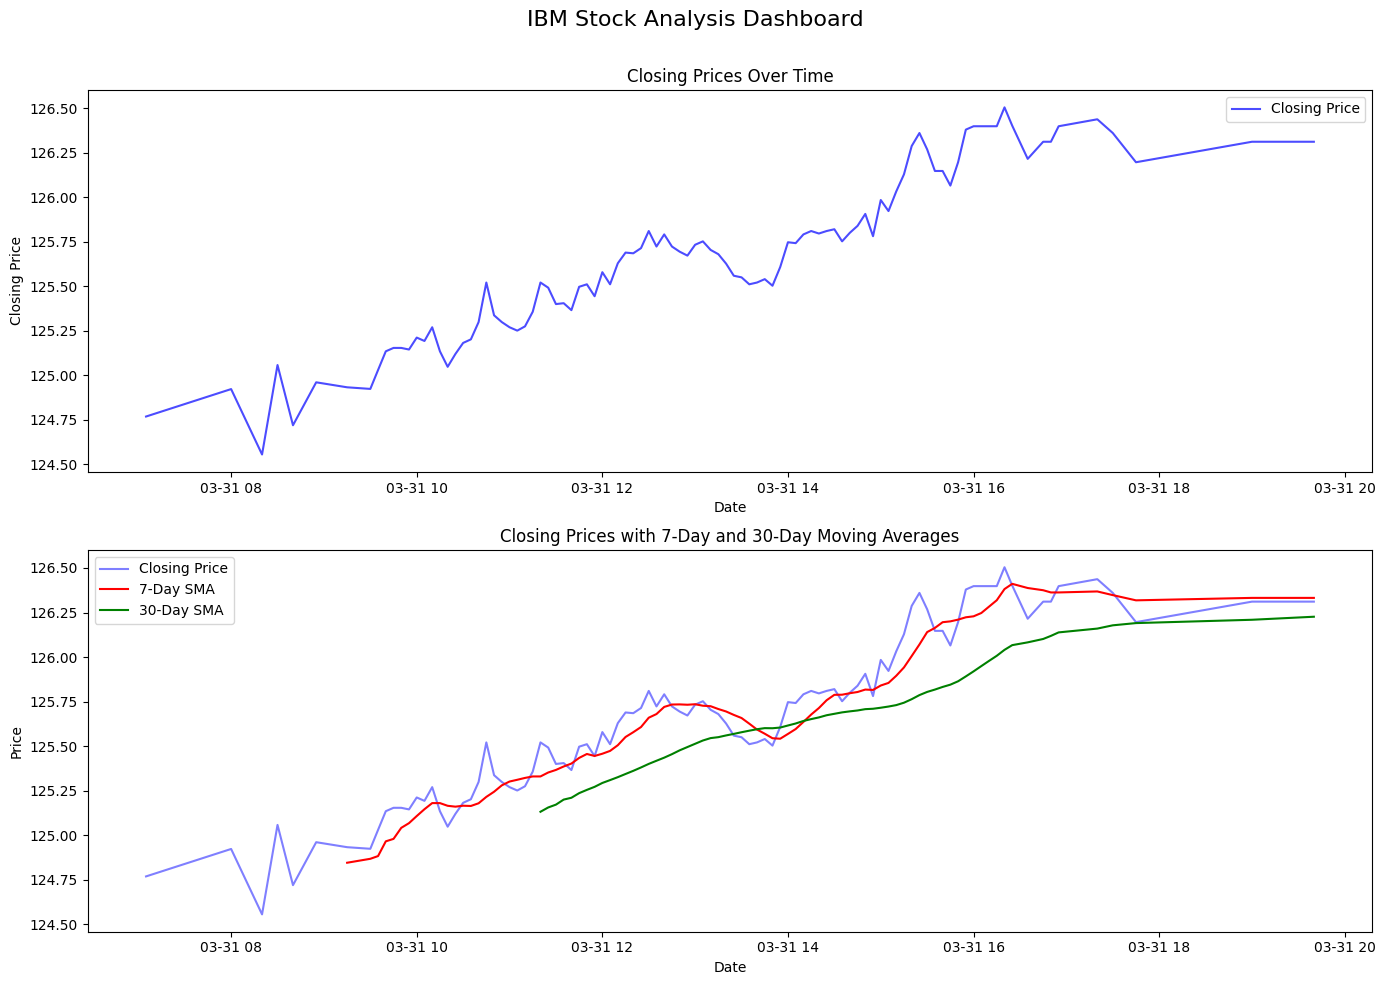

In [20]:



import pandas as pd
import matplotlib.pyplot as plt


print(df)

# Convert Spark DataFrame to Pandas DataFrame for plotting
pandas_df = df.toPandas()

pandas_df['open'] = pandas_df['open'].str.strip('"')
pandas_df['high'] = pandas_df['high'].str.strip('"')
pandas_df['low'] = pandas_df['low'].str.strip('"')
pandas_df['close'] = pandas_df['close'].str.strip('"')
pandas_df['volume'] = pandas_df['volume'].str.strip('"')


pandas_df['open'] = pandas_df['open'].astype(float)
pandas_df['low'] = pandas_df['low'].astype(float)
pandas_df['high'] = pandas_df['high'].astype(float)
pandas_df['close'] = pandas_df['close'].astype(float)
pandas_df['volume'] = pandas_df['volume'].astype(float)

# Ensure 'timeseries' column is of string type
pandas_df['timeseries'] = pandas_df['timeseries'].astype(str)

# Remove double quotes around the timestamp string
pandas_df['timeseries'] = pandas_df['timeseries'].str.strip('"')

# Convert 'date' column to datetime type
pandas_df['date'] = pd.to_datetime(pandas_df['timeseries'], format='%Y-%m-%d %H:%M:%S')

# Sort the DataFrame by date
pandas_df.sort_values('date', inplace=True)

# Setting up the figure for the dashboard
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10))
fig.suptitle("IBM Stock Analysis Dashboard", fontsize=16)

# Plot 1: Closing Prices
axes[0].plot(pandas_df['date'].values, pandas_df['close'].values, label='Closing Price', color='blue', alpha=0.7)
axes[0].set_title('Closing Prices Over Time')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Closing Price')
axes[0].legend()

# Calculate the moving averages
pandas_df['7_day_SMA'] = pandas_df['close'].rolling(window=7).mean()
pandas_df['30_day_SMA'] = pandas_df['close'].rolling(window=30).mean()

# Plot 2: Moving Averages
axes[1].plot(pandas_df['date'].values, pandas_df['close'].values, label='Closing Price', color='blue', alpha=0.5)
axes[1].plot(pandas_df['date'].values, pandas_df['7_day_SMA'].values, label='7-Day SMA', color='red')
axes[1].plot(pandas_df['date'].values, pandas_df['30_day_SMA'].values, label='30-Day SMA', color='green')
axes[1].set_title('Closing Prices with 7-Day and 30-Day Moving Averages')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Price')
axes[1].legend()

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show the dashboard
plt.show()

In [21]:
pandas_df.head()

,symbol,timeseries,open,high,low,close,volume,date,7_day_SMA,30_day_SMA
99,IBM,2023-03-31 07:05:00,124.802,124.807,124.747,124.769,200.0,2023-03-31 07:05:00,NaN,NaN
98,IBM,2023-03-31 08:00:00,124.957,124.962,124.901,124.923,155.0,2023-03-31 08:00:00,NaN,NaN
97,IBM,2023-03-31 08:20:00,124.590,124.595,124.535,124.556,100.0,2023-03-31 08:20:00,NaN,NaN
96,IBM,2023-03-31 08:30:00,125.092,125.097,125.036,125.058,105.0,2023-03-31 08:30:00,NaN,NaN
95,IBM,2023-03-31 08:40:00,124.754,124.759,124.698,124.720,346.0,2023-03-31 08:40:00,NaN,NaN


In [25]:
import plotly.express as px
fig = px.bar(pandas_df, x='timeseries', y='volume', color='symbol', title='Trading Volume Over Time')
fig.show()


In [24]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=pandas_df['timeseries'],
                open=df.toPandas()['open'],
                high=df.toPandas()['high'],
                low=df.toPandas()['low'],
                close=df.toPandas()['close'])])

fig.update_layout(title='Candlestick Chart', xaxis_title='Time', yaxis_title='Price')
fig.show()


In [23]:
fig = px.line(pandas_df, x='timeseries', y=['open', 'low', 'close'],
              labels={'value': 'Stock Price', 'timeseries': 'Time'},
              title='Stock Price Over Time with Moving Averages')
fig.show()


In [28]:

pandas_df['daily_return'] = pandas_df['close'].pct_change()
fig = px.scatter(pandas_df, x='timeseries', y='daily_return', color='symbol', title='Daily Returns')
fig.show()
